In [17]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
# from scipy import stats

In [18]:
# given budget，price vector (v_i)，mean return vector (mu_i).

# objective (minimize conditional value at risk, cvar): \min c  + 1/0.05 E[ (-sum \xi_i * v_i  * x_i - c)_+ ]

# s.t. 
# \sum x_i * v_i <= budget
# \sum \mu_i * v_i * x_i >= budget * 1.5
# x_i >= 0 integer

In [19]:
def sample_func(distribution_name, **dist_params):
     if hasattr(np.random, distribution_name):
        dist_func = getattr(np.random, distribution_name)
        samples = dist_func(**dist_params)
        return samples + 1 if distribution_name == "pareto" else samples
     else:
        raise ValueError(f"Unsupported distribution: {distribution_name}")
     

def sample_func_copy(distribution_name, **dist_params):
     if hasattr(np.random, distribution_name):
        dist_func = getattr(np.random, distribution_name)
        samples = dist_func(**dist_params)
        return samples + 1 if distribution_name == "pareto" else samples
     else:
        raise ValueError(f"Unsupported distribution: {distribution_name}")

def generate_covariance_matrix(m):
    A = np.random.rand(m, m)  
    cov_matrix = np.dot(A, A.T) 
    return cov_matrix

In [20]:
def majority_vote(sample_n, B, k, eval_func, *eval_args):
    x_count = {}
    for _ in range(B):
        # choose k samples from total n samples
        sample_k = sample_n[np.random.choice(sample_n.shape[0], k, replace=False)]
        x_k = tuple(eval_func(sample_k, *eval_args))
        x_count[x_k] = x_count.get(x_k, 0) + 1
    
    x_max = max(x_count, key=x_count.get)
    return x_max

In [21]:
def gurobi_portfolio(sample_xi, p, mu, b):
    # input:
    # sample_xi(random returns): k*m numpy array (where m is number of assets)
    # p(price): m*1 numpy array
    # mu(mean return): m*1 numpy array
    # b(budget): 1*1
    # output:
    # x(number of shares for each asset): m*1 numpy array

    k, m = sample_xi.shape
    model = Model("portfolio")
    model.setParam(GRB.Param.OutputFlag, 0)
    x = model.addVars(m, lb=0, vtype=GRB.INTEGER, name="x")
    c = model.addVar(lb=-float("inf"), vtype=GRB.CONTINUOUS, name="c")
    z = model.addVars(k, lb=0, vtype=GRB.CONTINUOUS, name="z")
    
    model.setObjective(c + 1/0.05 * 1/k * quicksum(z[i] for i in range(k)), GRB.MINIMIZE)
    
    model.addConstrs(z[i] >= -sum(sample_xi[i, j] * x[j] * p[j] for j in range(m)) - c for i in range(k))
    model.addConstr(quicksum(mu[j] * x[j] * p[j] for j in range(m)) >= 1.5*b)
    model.addConstr(quicksum(x[j] * p[j] for j in range(m)) <= b)

    model.optimize()

    if model.status == GRB.OPTIMAL:
        x_opt = np.array([x[j].X for j in range(m)])
        return x_opt
    else:
        print("No optimal solution found.")
        return None


In [22]:
def gurobi_second_stage(sample_xi, p, x):
    k, m = sample_xi.shape
    model = Model("second_stage")
    model.setParam(GRB.Param.OutputFlag, 0)
    c = model.addVar(vtype=GRB.CONTINUOUS, name="c")
    z = model.addVars(k, lb=0, vtype=GRB.CONTINUOUS, name="z")
    
    model.setObjective(c + 1/0.05 * 1/k * quicksum(z[i] for i in range(k)), GRB.MINIMIZE)
    
    model.addConstrs(z[i] >= -sum(sample_xi[i, j] * x[j] * p[j] for j in range(m)) - c for i in range(k))
    
    model.optimize()

    if model.status == GRB.OPTIMAL:
        return model.ObjVal
    else:
        print("No optimal solution found.")
        return None

In [112]:
# SAA and majority vote comparison
def comparison(mu, dist_paras,p, b,B,number_of_iterations,ratio,sample_number):
    name, paras = dist_paras["name"], dist_paras["paras"]
    
    SAA_list = []
    majority_list = []
    for n in sample_number:
        SAA_intermediate = []
        majority_intermediate = []
        for _ in range(number_of_iterations):
            if name == "multivariate_normal":
                sample_n = sample_func(name, size=n, mean=mu, cov=paras)
            elif name == "pareto":
                arrays_list = []
                for i in range(len(mu)):
                    arrays_list.append(sample_func(name, size=n, a=paras[i]))
                sample_n = np.vstack(arrays_list).T
            else: 
                raise ValueError(f"Unsupported distribution: {name}")
            SAA = majority_vote(sample_n, 1, n, gurobi_portfolio, p, mu, b)
            SAA_intermediate.append(SAA)
            majority = majority_vote(sample_n, B, int(n*ratio), gurobi_portfolio, p, mu, b)
            majority_intermediate.append(majority)
            
        SAA_list.append(SAA_intermediate)
        majority_list.append(majority_intermediate)
    return SAA_list, majority_list

def evaluation(SAA_list, majority_list, mu, dist_paras, p, number_of_iterations, sample_number, large_number_sample):
    name, paras = dist_paras["name"], dist_paras["paras"]
    if name == "multivariate_normal":
        large_sample = sample_func(name, size=large_number_sample, mean=mu, cov=paras)
    elif name == "pareto":
        arrays_list = []
        for i in range(len(mu)):
            arrays_list.append(sample_func(name, size=large_number_sample, a=paras[i]))
        large_sample = np.vstack(arrays_list).T
    else:
        raise ValueError(f"Unsupported distribution: {name}")

    SAA_obj_list = []
    majority_obj_list = []
    for i in range(len(sample_number)):
        SAA_obj = 0
        majority_obj = 0
        for j in range(number_of_iterations):
            SAA_obj += gurobi_second_stage(large_sample, p, SAA_list[i][j])
            majority_obj += gurobi_second_stage(large_sample, p, majority_list[i][j])  
            
        SAA_obj = SAA_obj/number_of_iterations
        majority_obj = majority_obj/number_of_iterations

        SAA_obj_list.append(SAA_obj)
        majority_obj_list.append(majority_obj)
    return SAA_obj_list, majority_obj_list

def figure_plot(SAA_obj_list, majority_obj_list,sample_number):
    # plot the objective values of SAA and Bagging-SAA
    _, ax = plt.subplots()
    ax.plot(sample_number, SAA_obj_list, marker = 'o', markeredgecolor = 'none', color = 'blue',linestyle = 'solid', linewidth = 2, label = 'SAA')
    ax.plot(sample_number, majority_obj_list, marker = 's', markeredgecolor = 'none', color = 'red',linestyle = 'solid', linewidth = 2, label = 'Majority Vote')
    ax.set_xlabel('Number of samples', size = 20)
    ax.set_ylabel('Objective', size = 20)
    ax.legend(loc = 'lower right')
    plt.show()
    return

In [102]:
# Random experiments
m = 8
mu = np.random.uniform(2, 5, m)
a_ls = np.divide(mu, mu-1)
cov_matrix = generate_covariance_matrix(m)
dist_paras_pareto = {"name": "pareto", "paras": a_ls}
dist_paras_normal = {"name": "multivariate_normal", "paras": cov_matrix}

p = np.random.uniform(0, 1, m)
b = np.random.uniform(1, 3)

B = 400
number_of_iterations = 10 # Number of iterations for each sample size (use to take average)
ratio = 0.2
sample_number = np.array([2**i for i in range(5, 16)])
large_number_sample = 1000000

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


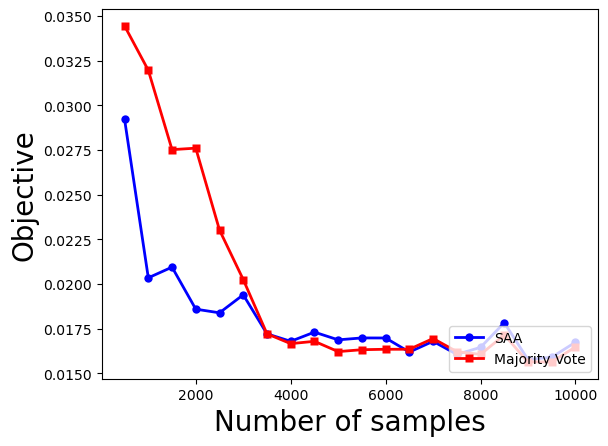

In [106]:
number_of_iterations = 20
sample_number = np.array([500*i for i in range(1, 21)])
# SAA_list, majority_list = comparison(mu, dist_paras_pareto, p, b, B, number_of_iterations, ratio, sample_number)
# SAA_obj_list, majority_obj_list = evaluation(SAA_list, majority_list, mu, dist_paras_pareto, p, number_of_iterations, sample_number, large_number_sample)
SAA_list, majority_list = comparison(mu, dist_paras_normal, p, b, B, number_of_iterations, ratio, sample_number)
SAA_obj_list, majority_obj_list = evaluation(SAA_list, majority_list, mu, dist_paras_normal, p, number_of_iterations, sample_number, large_number_sample)
figure_plot(SAA_obj_list, majority_obj_list, sample_number)

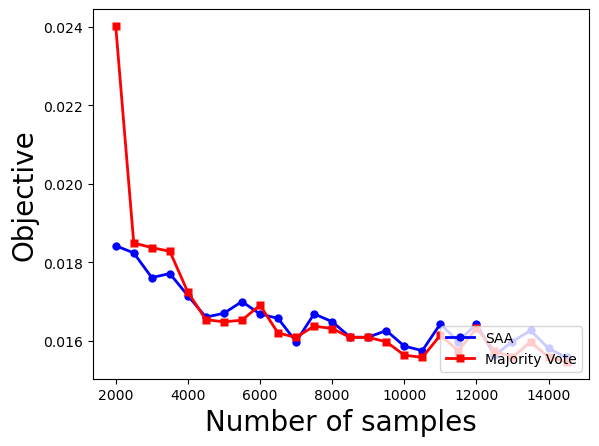

In [107]:
number_of_iterations = 50
sample_number = np.array([500*i for i in range(4, 30)])
# SAA_list, majority_list = comparison(mu, dist_paras_pareto, p, b, B, number_of_iterations, ratio, sample_number)
# SAA_obj_list, majority_obj_list = evaluation(SAA_list, majority_list, mu, dist_paras_pareto, p, number_of_iterations, sample_number, large_number_sample)
SAA_list, majority_list = comparison(mu, dist_paras_normal, p, b, B, number_of_iterations, ratio, sample_number)
SAA_obj_list, majority_obj_list = evaluation(SAA_list, majority_list, mu, dist_paras_normal, p, number_of_iterations, sample_number, large_number_sample)
figure_plot(SAA_obj_list, majority_obj_list, sample_number)

In [113]:
number_of_iterations = 50
sample_number = np.array([1000*i for i in range(3, 20)])
# SAA_list, majority_list = comparison(mu, dist_paras_pareto, p, b, B, number_of_iterations, ratio, sample_number)
# SAA_obj_list, majority_obj_list = evaluation(SAA_list, majority_list, mu, dist_paras_pareto, p, number_of_iterations, sample_number, large_number_sample)
SAA_list, majority_list = comparison(mu, dist_paras_normal, p, b, B, number_of_iterations, ratio, sample_number)
SAA_obj_list, majority_obj_list = evaluation(SAA_list, majority_list, mu, dist_paras_normal, p, number_of_iterations, sample_number, large_number_sample)
figure_plot(SAA_obj_list, majority_obj_list, sample_number)

KeyboardInterrupt: 

In [105]:
mu, dist_paras_normal, p, b

(array([4.57825599, 2.59539243, 3.63529675, 3.52406055, 3.24507009,
        4.72188993, 4.3935796 , 3.42740159]),
 {'name': 'multivariate_normal',
  'paras': array([[4.023997  , 2.40310981, 2.20044386, 2.17927984, 3.04517019,
          3.13852272, 3.0678499 , 2.57802196],
         [2.40310981, 1.92007872, 1.40783953, 1.35288294, 1.87754314,
          2.0765766 , 2.12928102, 1.8373703 ],
         [2.20044386, 1.40783953, 1.90733334, 1.76914087, 1.6352554 ,
          1.70005219, 2.06525868, 1.8454927 ],
         [2.17927984, 1.35288294, 1.76914087, 1.88579515, 1.63004875,
          1.62722018, 1.93102905, 1.83989155],
         [3.04517019, 1.87754314, 1.6352554 , 1.63004875, 3.2080927 ,
          2.61255376, 2.67144999, 1.98725729],
         [3.13852272, 2.0765766 , 1.70005219, 1.62722018, 2.61255376,
          2.95382297, 2.66526416, 1.99690051],
         [3.0678499 , 2.12928102, 2.06525868, 1.93102905, 2.67144999,
          2.66526416, 3.37273352, 2.01893774],
         [2.57802196, 1.8

In [86]:
def find_parameters(m,B,number_of_iterations,ratio,sample_number,large_number_sample):
    parameter_dict = {}
    SAA_list_test = []
    majority_list_test = []
    SAA_obj_list_test = []
    majority_obj_list_test = []
    prop_best = 0

    for _ in range(10):
        mu = np.random.uniform(2.9, 3.5, m)
        a_ls = np.divide(mu, mu-1)
        dist_paras_pareto = {"name": "pareto", "paras": a_ls}
        p = np.random.uniform(0, 2, m)
        b = np.random.uniform(2, 3)

        SAA_list, majority_list = comparison(mu, dist_paras_pareto, p, b, B, number_of_iterations, ratio, sample_number)
        SAA_obj_list, majority_obj_list = evaluation(SAA_list, majority_list, mu, dist_paras_pareto, p, number_of_iterations, sample_number, large_number_sample)

        prop = sum((SAA_obj_list[i]-majority_obj_list[i])/SAA_obj_list[i] for i in range(len(sample_number)//2,len(sample_number)))
        if prop > prop_best:
            prop_best = prop
            parameter_dict["mu"] = mu
            parameter_dict["a_ls"] = a_ls
            parameter_dict["p"] = p
            parameter_dict["b"] = b
            SAA_list_test = SAA_list
            majority_list_test = majority_list
            SAA_obj_list_test = SAA_obj_list
            majority_obj_list_test = majority_obj_list
    
    return parameter_dict, SAA_list_test, majority_list_test, SAA_obj_list_test, majority_obj_list_test


In [ ]:
# A good configuration under normal distribution
# m = 5
# mu = np.array([2.26833837, 2.99724413, 2.05634484, 2.22041616, 2.27772837])

# cov_matrix = np.array([[1.53992965, 1.45799569, 1.33721954, 1.29951018, 1.27703683],
#  [1.45799569, 1.46349095, 1.28561251, 1.11928718, 1.2290614 ],
#  [1.33721954, 1.28561251, 2.59160798, 1.50136609, 1.95532864],
#  [1.29951018, 1.11928718, 1.50136609, 1.58527353, 1.23659311],
#  [1.27703683, 1.2290614,  1.95532864, 1.23659311, 1.59685207]])

# p = np.array([0.21428391, 0.09577878, 0.82863508, 0.27561237, 0.88738926])
# b = 2.3308601852993753

In [9]:
# Testing: SAA and majority vote comparison - parameters setup

sample_number = np.array([2**i for i in range(10, 17)])
number_of_iterations = 10 # Number of iterations for each sample size (use to take average)
m = 3 # Number of items


# Generate samples for evaluation of optimal SAA and majority vote
large_number_sample = 1000000 
a_ls = np.full(m, 2) #np.random.rand(m)+1 # Pareto distribution parameter
arrays_list = []
for i in range(m):
    arrays_list.append(sample_func('pareto', size=large_number_sample, a=a_ls[i]))
large_sample = np.vstack(arrays_list).T

parameter_list = []
SAA_list_test = []
majority_list_test = []
SAA_obj_list_test = []
majority_obj_list_test = []

for num_test in range(10):
    print(num_test)
    c = float(np.random.uniform(3, 4, size=1)[0]) # Cost 
    q = float(np.random.uniform(0, 2, size=1)[0]) # Budget
    r = np.random.uniform(3, 4, size=m) # Rewards
    
    SAA_obj = 0
    majority_obj = 0
    flag = 0
    for n in sample_number:
        SAA_intermediate = []
        majority_intermediate = []
        for j in range(number_of_iterations):
            arrays_list = []
            for i in range(m):
                arrays_list.append(sample_func('pareto', size=n, a=a_ls[i]))
            sample_n = np.vstack(arrays_list).T
            SAA = majority_vote(sample_n, 1, n, gurobi_SSKP, r,c,q)
            SAA_intermediate.append(SAA)
            SAA_obj += optimal_eval(large_sample, SAA, r, c, q)

            majority = majority_vote(sample_n, 300, int(n/10), gurobi_SSKP, r,c,q)
            majority_intermediate.append(majority)
            majority_obj += optimal_eval(large_sample, majority, r, c, q)

        SAA_obj = SAA_obj/number_of_iterations
        majority_obj = majority_obj/number_of_iterations

        if SAA_obj > majority_obj:
            flag = 1
            break

    if flag == 1:
        continue 
    
    parameter_list.append([m, c, q, r])
    SAA_obj_list_test.append(SAA_obj)
    majority_obj_list_test.append(majority_obj)

0
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-20
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 21.3.0 21D62)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1024 rows, 1027 columns and 4096 nonzeros
Model fingerprint: 0xe3b60d0c
Variable types: 1024 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+02]
  Objective range  [3e-03, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective -0.0000000
Found heuristic solution: objective 4.6809689
Presolve removed 1024 rows and 1027 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 10 available processors)

Solution count 4: 4.68097 4.68097 4.68097 -0 

Optimal solution found (tolerance 1.00e-04

TypeError: 'NoneType' object is not iterable

In [1]:
# from ParallelSolve import gurobi_portfolio
import numpy as np

In [2]:
from scipy import stats

# generate pareto distributed samples
def genPareto(n, rng, paretoShape):
    return stats.lomax.rvs(paretoShape, size=n, random_state=rng) + 1

def genTruncatedNormal(n, rng, mean, std):
     return np.maximum(stats.norm.rvs(loc=mean, scale=std, size=n, random_state=rng),0)

def genSample_SSKP(n, rng, **kwargs):
     arrays_list = []
     if kwargs['type'] == 'pareto':
          paretoShapes = kwargs['params']
          for i in range(len(paretoShapes)):
               arrays_list.append(genPareto(n, rng, paretoShapes[i]))
     elif kwargs['type'] == 'normal':
          mean, std = kwargs['params'][0], kwargs['params'][1]
          for i in range(len(mean)):
               arrays_list.append(genTruncatedNormal(n, rng, mean[i], std[i]))
     else:
          raise ValueError('Invalid type')
     return np.vstack(arrays_list).T 


def genSample_portfolio(n, rng, **kwargs):
     # currently only consider uncorrelated samples
     if kwargs['type'] == 'pareto' or kwargs['type'] == 'normal':
          return genSample_SSKP(n, rng, type=kwargs['type'], params=kwargs['params'])
     elif kwargs['type'] == 'sym_pareto':
          # generate symmetric pareto distributed samples with mean specified by kwargs['params']
          paretoShapes = kwargs['params']
          pos_sample = genSample_SSKP(n, rng, type='pareto', params=paretoShapes)
          neg_sample = -genSample_SSKP(n, rng, type='pareto', params=paretoShapes)
          return pos_sample + neg_sample + np.array(paretoShapes)
     else:
          raise ValueError('Invalid type')

In [3]:
from gurobipy import Model, GRB, quicksum

def gurobi_portfolio(sample_xi, p, mu, b, alpha):
    # input:
    # sample_xi(random returns): k*m numpy array (where m is number of assets)
    # p(price): m*1 numpy array
    # mu(mean return): m*1 numpy array
    # b(budget): 1*1
    # output:
    # x(number of shares for each asset): m*1 numpy array

    # for consistency, use the maximization form

    k, m = sample_xi.shape
    model = Model("portfolio")
    model.setParam(GRB.Param.OutputFlag, 0)
    model.setParam('MIPGap', 0.00001)
    x = model.addVars(m, lb=0, vtype=GRB.INTEGER, name="x")
    c = model.addVar(lb=-float("inf"), vtype=GRB.CONTINUOUS, name="c")
    z = model.addVars(k, lb=0, vtype=GRB.CONTINUOUS, name="z")
    
    model.setObjective(c + 1/(1-alpha) * 1/k * quicksum(z[i] for i in range(k)), GRB.MINIMIZE)
    # model.setObjective(-c - 1/(1-alpha) * 1/k * quicksum(z[i] for i in range(k)), GRB.MAXIMIZE)
    
    model.addConstrs(z[i] >= -quicksum(sample_xi[i, j] * x[j] * p[j] for j in range(m)) - c for i in range(k))
    model.addConstr(quicksum(mu[j] * x[j] * p[j] for j in range(m)) >= 1.5*b)
    model.addConstr(quicksum(x[j] * p[j] for j in range(m)) <= b)
    model.setParam("Threads", 1)

    model.optimize()

    if model.status == GRB.OPTIMAL:
        x_opt = np.array([round(x[j].X) for j in range(m)])
        objVal = model.ObjVal
        return x_opt, objVal
    else:
        print("No optimal solution found.")
        return None

def gurobi_evaluate(sample_xi, x, p, mu, b, alpha):
    k, m = sample_xi.shape
    model = Model("portfolio")
    model.setParam(GRB.Param.OutputFlag, 0)
    model.setParam('MIPGap', 0.00001)
    c = model.addVar(vtype=GRB.CONTINUOUS, name="c")
    z = model.addVars(k, lb=0, vtype=GRB.CONTINUOUS, name="z")

    model.setObjective(c + 1/(1-alpha) * 1/k * quicksum(z[i] for i in range(k)), GRB.MINIMIZE)
    model.addConstrs(z[i] >= -quicksum(sample_xi[i, j] * x[j] * p[j] for j in range(m)) - c for i in range(k))
    model.setParam("Threads", 1)

    model.optimize()

    if model.status == GRB.OPTIMAL:
        objVal = model.ObjVal
        return objVal
    else:
        print("No optimal solution found.")
        return None

def portfolio_evalute_wSol(sample_n, x, p, mu, b, alpha):
    # portfolio evaluation function, basically computing the cVar directly.
    # p and alpha are problem parameters
    losses = - np.dot(sample_n, np.array(x) * np.array(p))
    idx = min(int(len(losses) * alpha), len(losses) - 1)
    var_threshold = np.quantile(losses, idx / (len(losses) - 1))
    cvar = np.sum(losses[losses > var_threshold] - var_threshold) / len(losses) / (1- alpha) + var_threshold
    return cvar, x

def calculate_cvar(sample_xi, x, p, mu, b, alpha):
    losses = - np.dot(sample_xi, np.array(x) * np.array(p))
    var_threshold = np.quantile(losses, alpha)
    cvar = np.mean(losses[losses > var_threshold])
    return cvar, x

In [4]:
seed = 2024
m = 6
# mu = np.random.uniform(2,5, m)
mu = np.array(
    [
1.8631027879562767,
1.4816165666258216,
3.8350381262187425,
1.8519773123288035,
2.2214940494665254,
2.0481354644229883
]
)

p = np.array(
    [
1.1348675017166183,
1.1791532826500637,
0.31745153638817203,
0.3855963983383617,
0.29554738723061535,
0.27972984236957976
])

b = 1.4935663178438674

sample_args = {
    "type" : "sym_pareto",
    "params": mu.tolist()
}

# p = np.random.uniform(0, 1, m)
# b = np.random.uniform(1, 3)

sample_number = np.array([2**i for i in range(5, 20)])
large_number_sample = 500000
alpha = 0.95

rng_sample = np.random.default_rng(seed=seed)

In [6]:
for n in sample_number:
    sample_n = genSample_portfolio(n, rng_sample, type = sample_args["type"], params = sample_args["params"])
    SAA, obj_SAA = gurobi_portfolio(sample_n, p, mu, b, alpha)
    # sample_large = genSample_portfolio(large_number_sample, rng_sample, type = sample_args["type"], params = sample_args["params"])
    # obj_eval = gurobi_evaluate(sample_large, SAA, p, mu, b, alpha)
    # print(SAA, obj_SAA, obj_eval)
    # obj, x = portfolio_evalute_wSol(sample_n, SAA, p, mu, b, alpha)
    # print(SAA, obj_SAA, obj)
    sample_large = genSample_portfolio(large_number_sample, rng_sample, type = sample_args["type"], params = sample_args["params"])
    obj, x = portfolio_evalute_wSol(sample_large, SAA, p, mu, b, alpha)
    obj2, x2 = calculate_cvar(sample_large, SAA, p, mu, b, alpha)
    print(SAA, obj_SAA, obj, obj2)

[0 0 4 0 0 0] -4.109856950816804 -2.7121400649855407 -2.71214006498554
[0 0 4 0 0 0] -2.5698640451802652 -2.68900653903591 -2.6890065390359097
[0 0 4 0 0 0] -2.7833454985392176 -2.7049392475980434 -2.7049392475980425
[0 0 4 0 0 0] -2.882154079799747 -2.6919025763095163 -2.6919025763095155
[0 0 4 0 0 0] -2.9705689746644475 -2.7121316700338616 -2.712131670033861
[0 0 4 0 0 0] -2.786495004998651 -2.7098905781126787 -2.709890578112678
[0 0 4 0 0 0] -2.468396636793055 -2.695873233270232 -2.6958732332702313
[0 0 4 0 0 0] -2.6560768048562506 -2.709695065757319 -2.7096950657573187
[0 0 4 0 0 0] -2.6491869135851456 -2.7092982983874547 -2.7092982983874543
[0 0 4 0 0 0] -2.7650586762003035 -2.6950542292351063 -2.695054229235106
[0 0 4 0 0 0] -2.6514207060736004 -2.704570391332087 -2.7045703913320858
[0 0 4 0 0 0] -2.674698412892228 -2.702749876623164 -2.702749876623163
[0 0 4 0 0 0] -2.715627675534304 -2.7019563788115244 -2.7019563788115235

Interrupt request received
No optimal solution found.


TypeError: cannot unpack non-iterable NoneType object

In [7]:
import json
with open('obj_lists.json', 'r') as f:
    results = json.load(f)

In [8]:
results.keys()

dict_keys(['SAA_obj_list', 'SAA_obj_avg', 'bagging_alg1_obj_list', 'bagging_alg1_obj_avg', 'bagging_alg3_obj_list', 'bagging_alg3_obj_avg', 'bagging_alg4_obj_list', 'bagging_alg4_obj_avg'])

In [11]:
SAA_obj_list = results['SAA_obj_list']
SAA_obj_avg = results['SAA_obj_avg']
bagging_alg1_obj_list = results['bagging_alg1_obj_list']
bagging_alg1_obj_avg = results['bagging_alg1_obj_avg']
bagging_alg3_obj_list = results['bagging_alg3_obj_list']
bagging_alg3_obj_avg = results['bagging_alg3_obj_avg']
bagging_alg4_obj_list = results['bagging_alg4_obj_list']
bagging_alg4_obj_avg = results['bagging_alg4_obj_avg']

In [10]:
from utils.plotting import plot_twoPhase, plot_CI_twoPhase

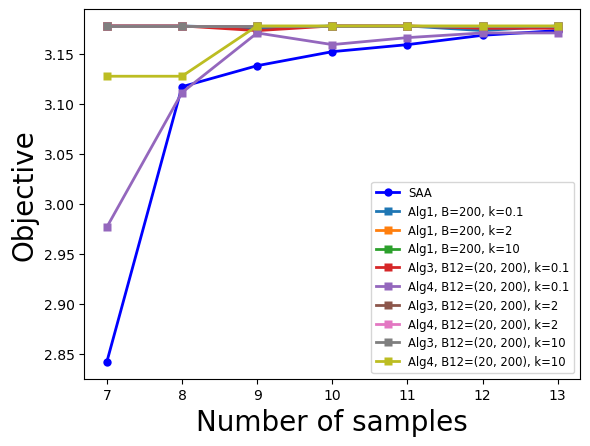

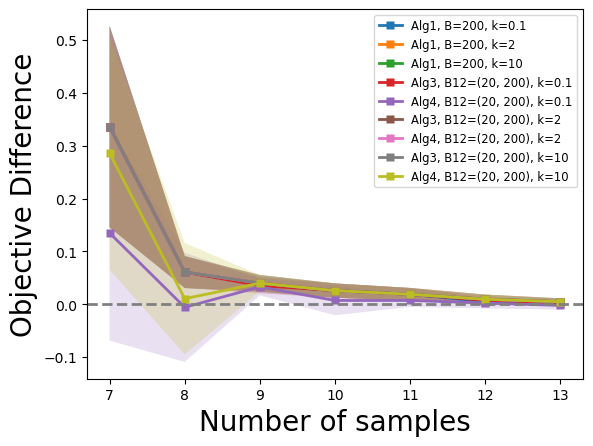

In [14]:
B_list = [200, 'X']
k_list = [0.1, 2, 10, 'X']
B12_list = [(20,200), 'X']
sample_number = np.array([2**i for i in range(7, 14)])
plot_twoPhase(SAA_obj_avg, bagging_alg1_obj_avg, bagging_alg3_obj_avg, bagging_alg4_obj_avg, np.log2(sample_number), B_list, k_list, B12_list)
plot_CI_twoPhase(SAA_obj_list, bagging_alg1_obj_list, bagging_alg3_obj_list, bagging_alg4_obj_list, np.log2(sample_number), B_list, k_list, B12_list)

In [1]:
from ParallelSolve import gurobi_portfolio_continuous
import numpy as np
sample_xi = np.random.randn(100, 3)
mu = [1,2,3]
b = 2

x_opt = gurobi_portfolio_continuous(sample_xi, mu, b)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13


In [2]:
x_opt

array([0.18860957, 0.62278085, 0.18860957])

: 